#### Grism calib
This script reads a FITS image containing a dispersed grism spectrum and applies wavelength and gain calibration read from a previously generated calibration file. It rederives wavelength and flux calibrations, and stores them as a csv in standard cal file formatting. 

V. 1.0 (9 May 2024) CHR. 


## imports and definitions

In [19]:
from grism_utils import *
import os,sys
import glob
from astropy.io import fits
import numpy as np
import numpy.ma as ma
from astropy.io.fits import getdata
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import rotate
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.ndimage import maximum_filter1d
from scipy.signal import medfilt, find_peaks, detrend
from datetime import datetime
import smplotlib
import csv


balmer = np.array([397.0, 410.17, 434.05, 486.14, 656.45])
deg = np.pi/180.

In [20]:
#select grism image (right click -> "copy path")
grism_image = '/Users/research/Desktop/cain/analysis/grism/lab10/images/HD116608-0001_lowres.fts'

#select cal file (right click -> "copy path")
cal_file = '/Users/research/Desktop/cain/analysis/grism/scripts/grism_cal(HD116608).csv'

In [21]:
def read_calfile(fname):
    ''' Reads grism calibration file (.csv), extracts header line, subimage box, rotation angle, 
    and coefficients to generate functions that convert pixels to wavelength and gain vs wavelength'''
    with open(fname,'r') as f:
        lines = f.read().split('\n')
        hdr_line = lines[0]
        box = [int(x) for x in lines[1].split(',')]
        angle = float(lines[2])
        wavelength_coefficients = np.array([float(x) for x in lines[3].split(',')])
        gain_coefficients = np.array([float(x) for x in lines[4].split(',')] )    
    return(hdr_line, box, angle, wavelength_coefficients, gain_coefficients)

## getting uncalibrated data

In [22]:
if os.path.exists(grism_image):
    im, hdr = getdata(grism_image, 0, header=True)
    object_name = hdr['OBJECT']
    obs_date = hdr['DATE-OBS']
    print(f"Found grism image: {grism_image}.")
else:
    print('Cannot find %s, stopping' % grism_image)
    raise StopExecution  

## USE "INTRUME" KEYWORD TO IDENTIFY CAMERA

if os.path.exists(cal_file):
    print(f"Found calibration file: {cal_file}")
else:
    print('Cannot find %s, stopping' % cal_file)
    raise StopExecution  


Found grism image: /Users/research/Desktop/cain/analysis/grism/lab10/images/HD116608-0001_lowres.fts.
Found calibration file: /Users/research/Desktop/cain/analysis/grism/scripts/grism_cal(HD116608).csv


Creating subimage...
Drawing box at 550,748 with dimensions 1200,50
Full image dimensions: 2048,2048
Rotation angle = 357 deg
Maximum ADU count in subimage = 934
Object: HD116608


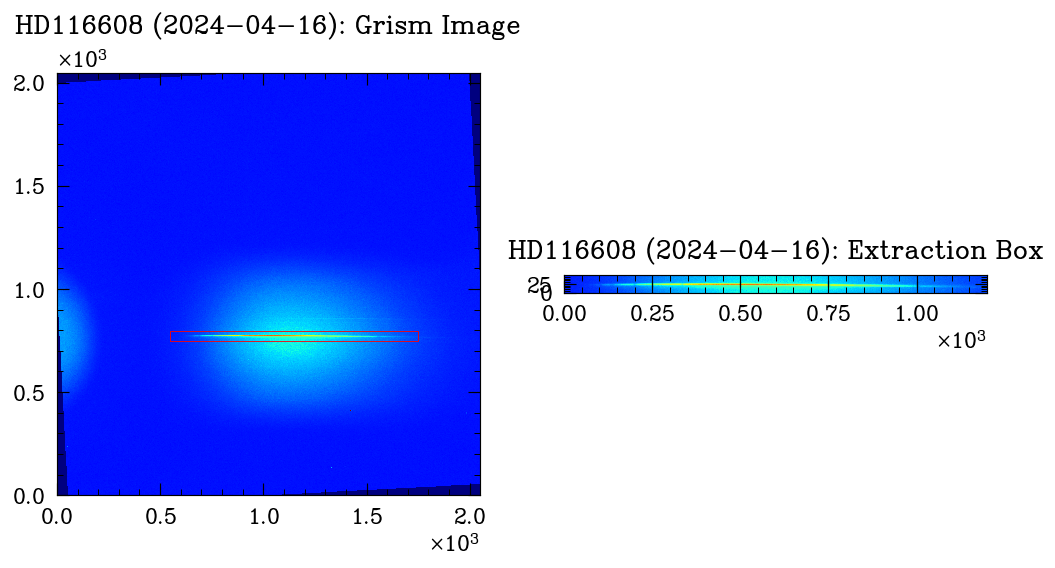

In [23]:
# getting data from image and calibration file
cal_hdr, box, rot_angle, wavelength_coefficients, gain_coefficients = read_calfile(cal_file)
f_wave = np.poly1d(wavelength_coefficients)
f_gain = np.poly1d(gain_coefficients)


# defining subimage box dimensions as specified by user
print('Creating subimage...')
xi,yi = im.shape
xstart = 550
ystart = 748
xwidth = 1200
ywidth = 50
rotangle = 357
mybox  = [xstart,ystart,xwidth,ywidth]
print(f'Drawing box at {xstart},{ystart} with dimensions {xwidth},{ywidth}')
print(f'Full image dimensions: {xi},{yi}')
print(f'Rotation angle = {rotangle} deg')

# Instantiate with rotation angle and subimage box
B = grism_utils(grism_image,cal_file,rotangle,mybox,f_wave,f_gain)

# Create subimage using optional box parameters
subim,transim = B.create_box()
xs,ys = subim.shape
zmax = np.max(subim)
print(f'Maximum ADU count in subimage = {zmax}')

# Plot subimage

object_name, obs_date,telescope,camera,title,im,rot_angle, box, _,_ = B.summary_info()
fig = B.plot_box(image=transim,subim=subim,figsize =(10,10),cmap='jet',box=mybox)
print(f'Object: {object_name}')


Plotting uncalibrated spectrum...


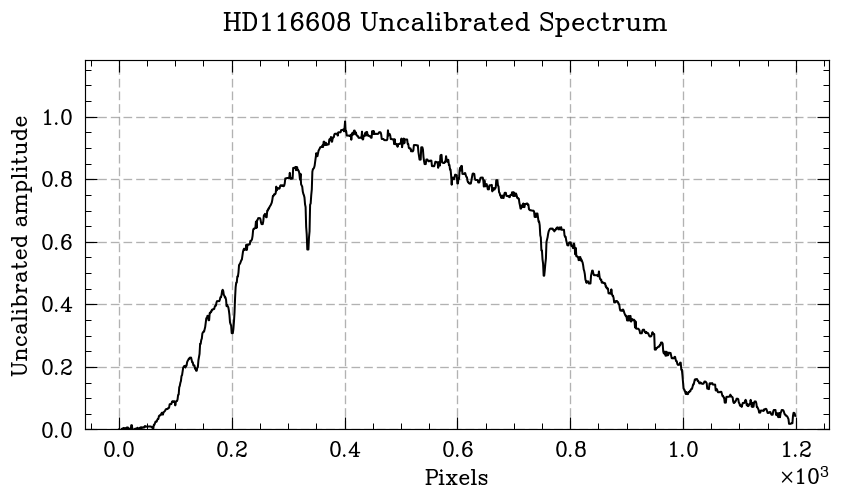

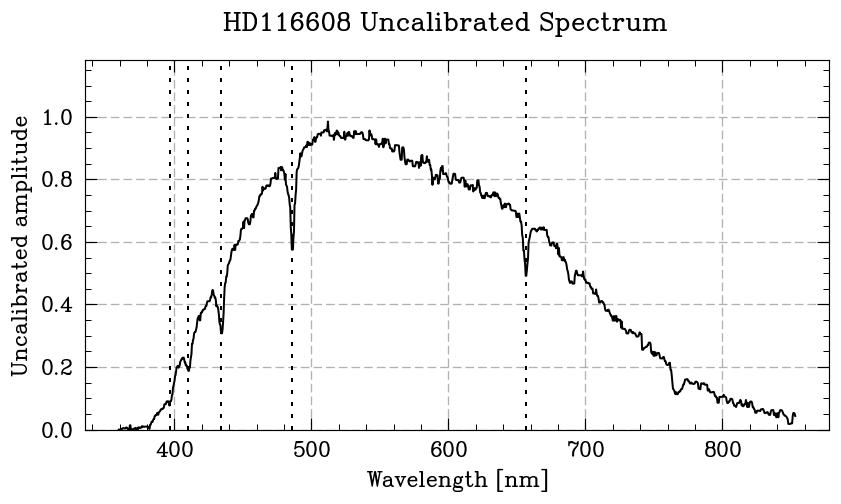

In [24]:
print('Plotting uncalibrated spectrum...')
B = grism_utils(grism_image,cal_file,rot_angle,mybox,f_wave,f_gain)
object_name, obs_date,telescope,camera,title,im,rot_angle, box, _,_ = B.summary_info()

spectrum = B.calibrate_spectrum(subim, norm=True)
fig = B.plot_spectrum(spectrum, xaxis='pixel', yaxis='uncal', subrange = slice(0,len(spectrum[0])),\
                    title='%s Uncalibrated Spectrum' % object_name, medavg = 5,xlims =[0,0],ylims =[0,0])
fig.show()
fig2 = B.plot_spectrum(spectrum, xaxis='wave', yaxis='uncal', subrange = slice(0,len(spectrum[0])),\
                    title='%s Uncalibrated Spectrum' % object_name, medavg = 5,plot_balmer=True,xlims =[0,0],ylims =[0,0])
fig2.show()
# fig = B.plot_gain_curve(spectrum,color='r',title='Gain curve')

# fig = B.plot_spectrum(spectrum, xaxis='wave', yaxis='cal',medavg=7, title='%s Calibrated Spectrum' % object_name,
# xlims=[401,749],plot_balmer=True)

In [25]:
# exctract spectrum information
pixels, waves, amp_uncal, amp_cal = spectrum

## deriving wavelength calibration

the important things are are the definitions for 'lines' and 'up_range'/'down_range'. Use 'uncal_lines' to define the wavelengths of the lines you want to fit. Use 'up_range'/'down_range' to set the range above or below that line to search. 

Fitting Balmer Gaussian...
Wave_ctr = 434.2 +/- 0.1 nm, FWHM = 4.9 +/- 0.2 nm
Wave_ctr = 486.2 +/- 0.1 nm, FWHM = 4.5 +/- 0.2 nm
Wave_ctr = 656.7 +/- 0.1 nm, FWHM = 3.8 +/- 0.3 nm
The fitted pixel peaks are: [200.0, 335.0, 753.0], compared to the real wavelengths: [434.05, 486.14, 656.45]


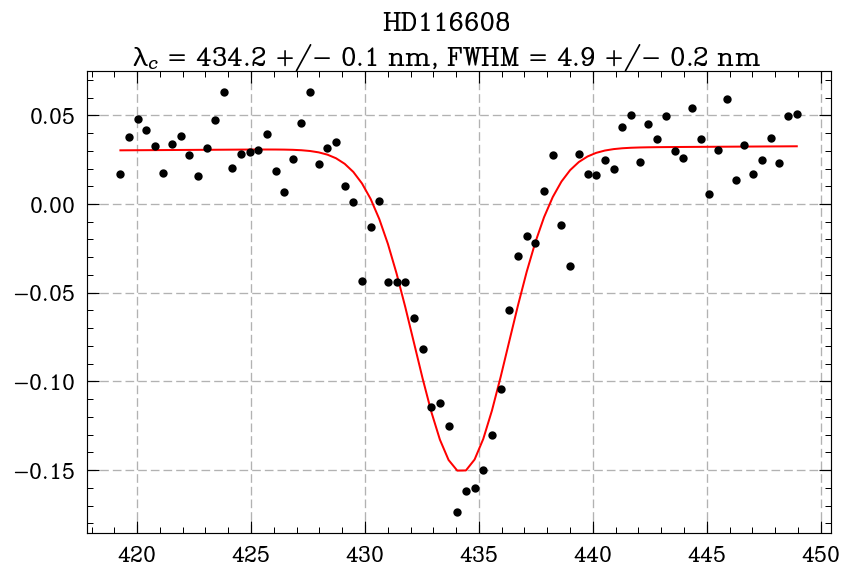

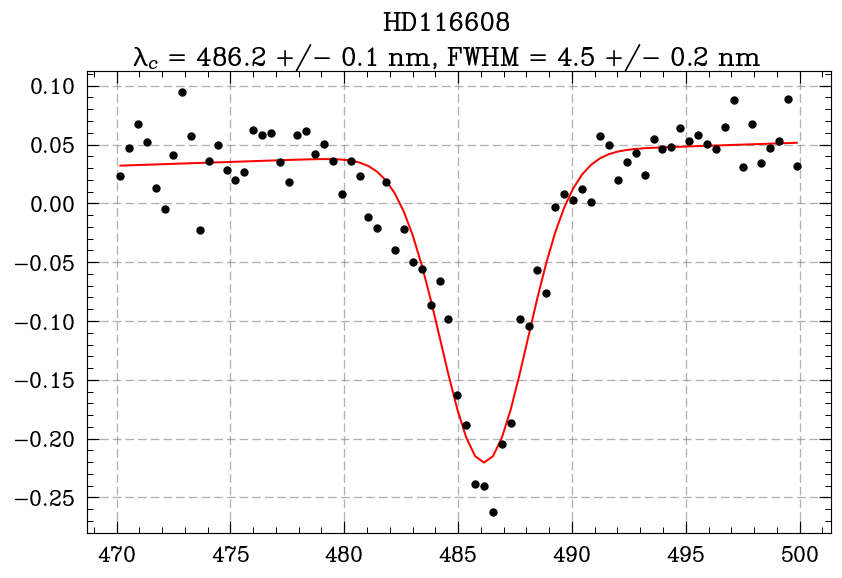

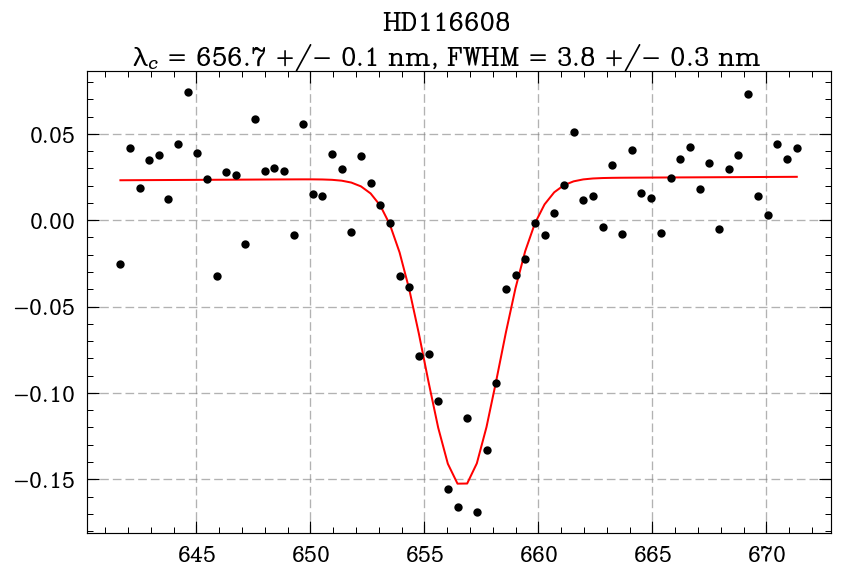

In [26]:
# identify and fit gaussians

#enter true wavelengths of lines you're fitting
ref_wave = [434.05,486.14,656.45]
#enter the uncalibrated wavelenghts of the lines you're fitting
uncal_wave = np.array([434.05,485.14,656.45])

if len(uncal_wave) < 2:
    print('Must fit for at least 2 lines')
    raise StopExecution()

up_range = 15
down_range = 15

def close_ind(lst, K):

    return min(range(len(lst)), key = lambda i: abs(lst[i]-K))

peak_px = []

print('Fitting Balmer Gaussian...')
wave_min= []
wave_max= []
for i in range(len(uncal_wave)):
    wave_min.append(uncal_wave[i]-down_range)
    wave_max.append(uncal_wave[i]+up_range)
for i in range(len(uncal_wave)):
    params, wave, amp, amp_mod = B.fit_spectral_line(spectrum,wave_min[i],wave_max[i])
    wave_ctr,wave_ctr_err,fwhm,fwhm_err,a,a_err = params
    #if np.abs(a) > 100 and fwhm > 2:
    print(f'Wave_ctr = {round(wave_ctr, 1)} +/- {round(wave_ctr_err, 1)} nm, FWHM = {round(fwhm, 1)} +/- {round(fwhm_err, 1)} nm' )
    fig = B.plot_spectral_line(wave,amp,amp_mod,wave_ctr,wave_ctr_err,fwhm,fwhm_err,color='red',title=object_name)
    ind_ctr = close_ind(waves, wave_ctr)
    px_ctr = pixels[ind_ctr]
    peak_px.append(px_ctr)

print(f'The fitted pixel peaks are: {peak_px}, compared to the real wavelengths: {ref_wave}')
    
    

In [27]:
#derive new wavelength coefficients

def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

def linear(x, a, b):
    return a * x + b

if len(uncal_wave) == 2:
    mode = linear
else:
    mode = quadratic

params, _ = curve_fit(mode, peak_px, ref_wave)

print(f'new wavelength coefficients are {params}')

new wavelength coefficients are [3.90385887e-05 3.64966207e-01 3.59495215e+02]


## getting reference spectrum

In [28]:
fn = open('/Users/research/Desktop/cain/analysis/grism/fluxes.dat')
lines = fn.readlines()
names = []
for line in lines:
	name = line[0:9].replace(' ','')
	names.append(name)
	fluxes = line[10:].split()
unique_names = list(set(names))

In [29]:
data = {}
for name in unique_names:
	flux = []
	for line in lines:
		if name == line[0:9].replace(' ',''):
			fluxline = [float(line[i:i+10]) for i in range(10,len(line)-1,10)]
			flux += fluxline
	data[name] = flux

2799


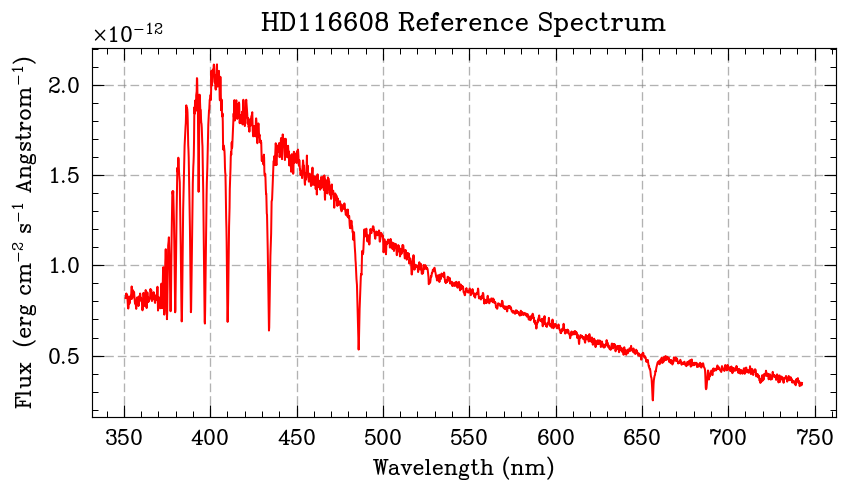

In [30]:
star = object_name

plt.figure(1,figsize=(8,4))
fluxes = np.array(data[star])
lambda1 = 351.0
print(len(fluxes))
jwaves =  0.14*np.arange(len(fluxes))
jwaves += 351.0
plt.plot(jwaves,fluxes,'r-')
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'Flux  (erg cm$^{-2}$ s$^{-1}$ Angstrom$^{-1}$)')
plt.title('%s' % star + ' Reference Spectrum')
plt.grid(True)
plt.show()


## deriving flux calibration (gain curve)

2799 1200
2799 1200


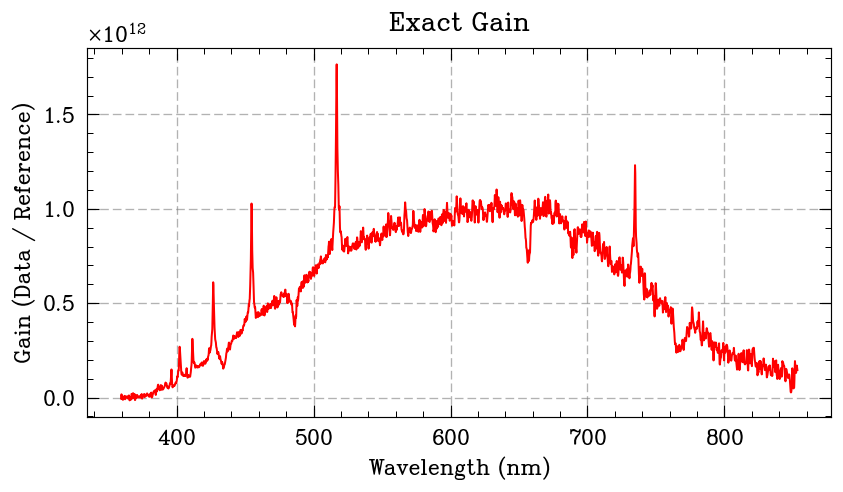

In [31]:
# make spectra the same shape

def interpolate_data(data, new_size):
    old_size = len(data)
    x_old = np.linspace(0, 1, old_size)
    x_new = np.linspace(0, 1, new_size)
    
    interpolated_data = np.interp(x_new, x_old, data)
    
    return interpolated_data


new_size = len(jwaves)  
wave_interp = interpolate_data(waves, new_size)
amp_interp = interpolate_data(amp_uncal, new_size)

#check sizes
print(len(wave_interp), len(waves))
print(len(amp_interp), len(amp_uncal))

#devide spectra
gain=amp_interp/fluxes
x = wave_interp
y = gain

plt.figure(1,figsize=(8,4))
plt.plot(x,y,'r-')
#plt.ylim(0,1)
#plt.xlim(300,750)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Gain (Data / Reference)')
plt.title('Exact Gain')
plt.grid(True)
plt.show()



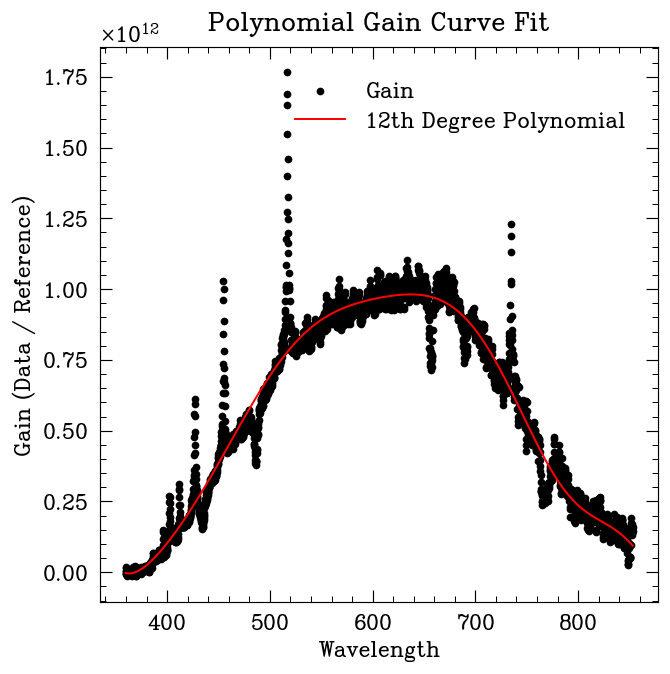

new flux coefficients are [ 5.82851500e-18 -3.25082184e-14  7.86017935e-11 -1.07134679e-07
  8.92016703e-05 -4.55318757e-02  1.33521302e+01 -2.11844023e+03
  6.42541566e+05 -4.98202635e+08  1.99791849e+11 -3.76523456e+13
  2.78139603e+15]


In [32]:
## fit gain curve to smooth polynomial 

# Define the function to fit (10th degree polynomial)
def polynomial_function(x, *coefficients):
    return np.polyval(coefficients, x)

x = wave_interp
y = gain
degree = 12

# Fit a polynomial to the data
initial_guess = np.ones(degree+1)  # Initial guess for the coefficients
coefficients, _ = curve_fit(polynomial_function, x, y, p0=initial_guess)
fit =  polynomial_function(x, *coefficients)

# Plot the original data and the fitted polynomial
plt.scatter(x, y,s=13, label='Gain')
plt.plot(x, fit, color='red', label=f'{degree}th Degree Polynomial')
plt.legend()
# plt.xlim(300,900)
# plt.ylim(0,2e12)
plt.xlabel('Wavelength')
plt.ylabel('Gain (Data / Reference)')
plt.title('Polynomial Gain Curve Fit')
plt.show()

print(f'new flux coefficients are {coefficients}')


Text(0.5, 1.0, 'Refining Gain')

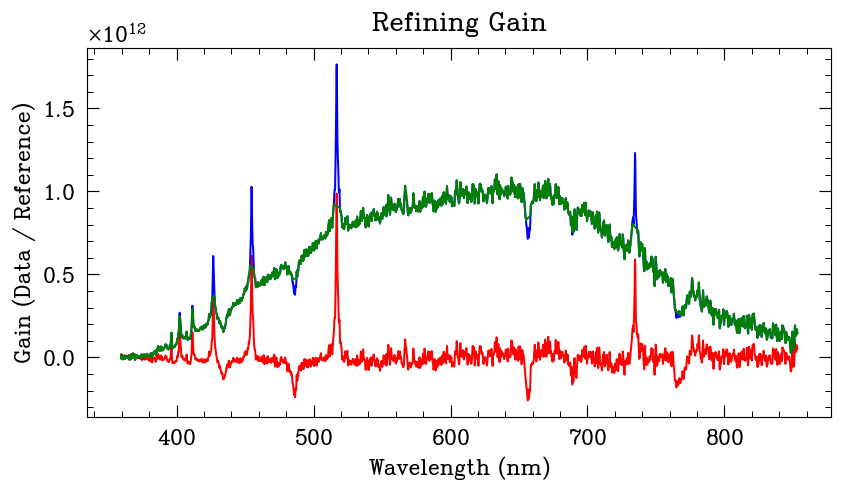

In [33]:
residuals = gain - polynomial_function(x, *coefficients)


gain2 = gain[np.abs(residuals) < 1.5e11]
wave_interp2  = wave_interp[np.abs(residuals) < 1.5e11]

plt.figure(1,figsize=(8,4))
plt.plot(x,residuals,'r-',label='Residuals')
plt.plot(x,gain,'b-',label='Exact Gain')
plt.plot(wave_interp2,gain2,'g-',label='Refined Gain')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Gain (Data / Reference)')
plt.title('Refining Gain')



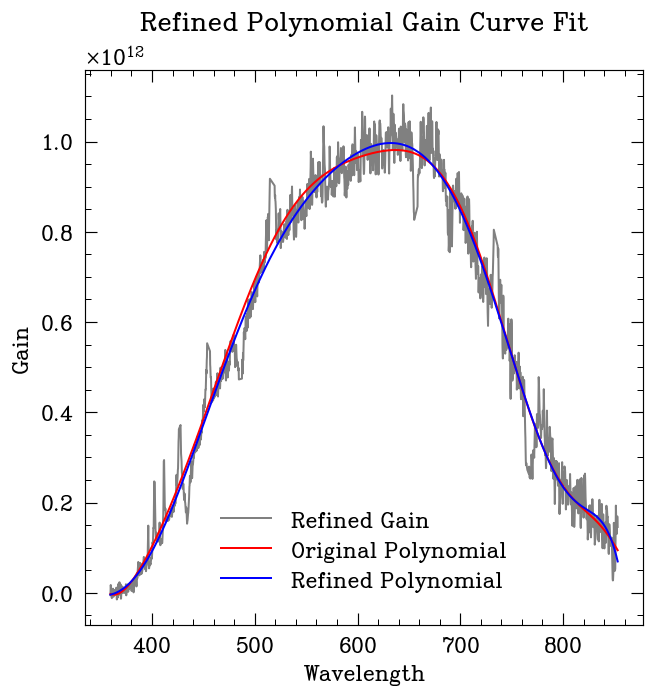

In [34]:

x2 = wave_interp2
y2 = gain2
degree = 10

# Fit a polynomial to the data
initial_guess2 = np.ones(degree+1)  # Initial guess for the coefficients
coefficients2, _ = curve_fit(polynomial_function, x2, y2, p0=initial_guess2)
fit2 =  polynomial_function(x2, *coefficients2)

# Plot the original data and the fitted polynomial
plt.plot(x2, y2, label='Refined Gain',c='gray')
plt.plot(x, fit, color='red', label=f'Original Polynomial')
plt.plot(x2, fit2, color='blue', label=f'Refined Polynomial')
plt.legend()
# plt.xlim(300,900)
# plt.ylim(0,2e12)
plt.xlabel('Wavelength')
plt.ylabel('Gain')
plt.title('Refined Polynomial Gain Curve Fit')
plt.show()

## write out to cal file

In [35]:
with open(f'grism_cal({object_name}).csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([f'Grism calibration for {object_name} observed {obs_date} created using python'])
        writer.writerow(mybox)
        writer.writerow([rotangle])
        writer.writerow(params)
        writer.writerow(coefficients2)